# RAG system
#### Group members:
**Kian Eliasi Boroujeni**, **Nicola Francescon**, **Michał Jagoda**, **Vittorio La Ferla**

## RAG workflow diagram

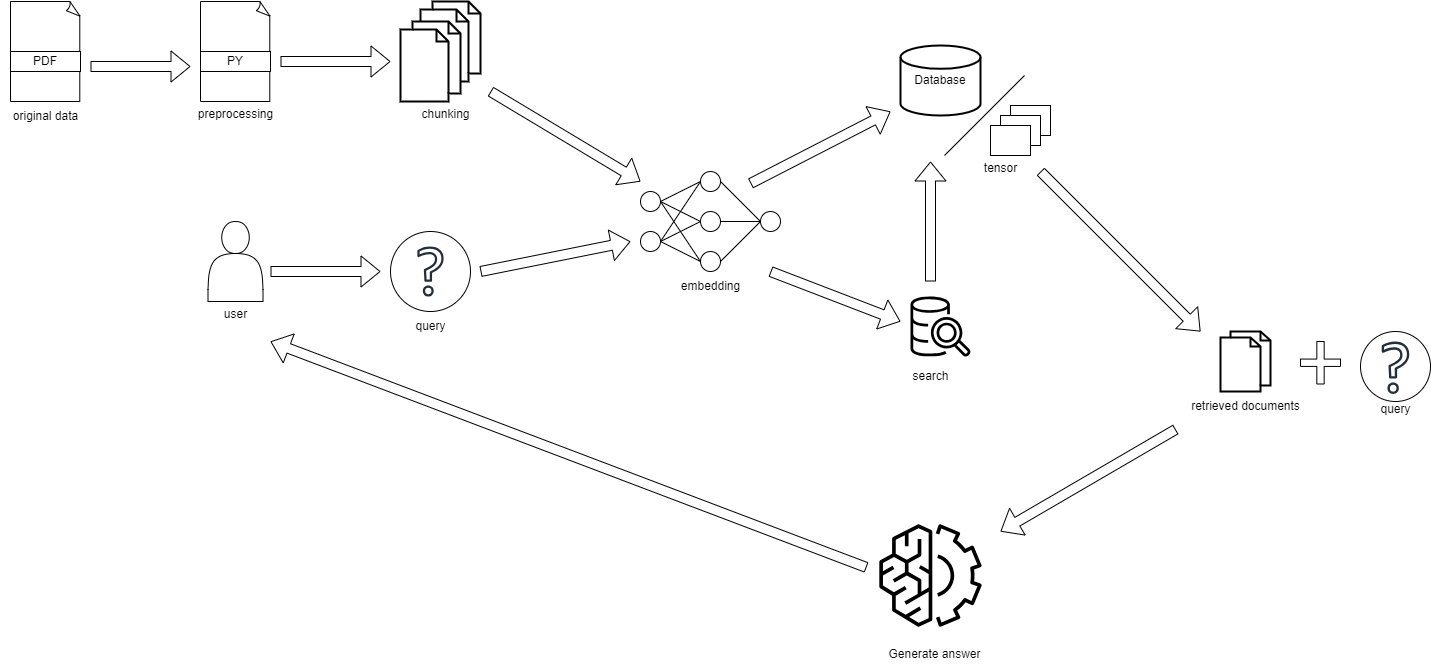

In [1]:
# Perform Google Colab installs (if running in Google Colab)
import os
if True:
#if "COLAB_GPU" in os.environ:
    print("[INFO] Running in Google Colab, installing requirements.")
    !pip install -U torch # requires torch 2.1.1+ (for efficient sdpa implementation)
    !pip install PyMuPDF # for reading PDFs with Python
    !pip install tqdm # for progress bars
    !pip install sentence-transformers # for embedding models
    !pip install accelerate # for quantization model loading
    !pip install bitsandbytes # for quantizing models (less storage space)
    !pip install flash-attn --no-build-isolation # for faster attention mechanism = faster LLM inference
    !pip install datasets
    !pip install seaborn
    !pip install spacy

[INFO] Running in Google Colab, installing requirements.
  Using cached flash_attn-2.5.8.tar.gz (2.5 MB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [20 lines of output]
      fatal: not a git repository (or any of the parent directories): .git
      /var/tmp/pip-install-9l9ci4g_/flash-attn_39a62b6e4948447ea3d563eee0e75c66/setup.py:78: UserWarning: flash_attn was requested, but nvcc was not found.  Are you sure your environment has nvcc available?  If you're installing within a container from https://hub.docker.com/r/pytorch/pytorch, only images whose names contain 'devel' will provide nvcc.
        warnings.warn(
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "/var/tmp/pip-install-9l9ci4g_/flash-attn_39a62b6e4948447ea3d563eee0e75c66/setup.py", line 134, in <m

In [2]:
# import os
# from google.colab import drive
# drive.mount('/content/drive')

# path = 'Colab Notebooks/NLP/Project'

# os.chdir(f'/content/drive/MyDrive/{path}')
# os.getcwd()

In [3]:
# import pandas as pd

# list_contexts = pd.read_pickle("/content/drive/MyDrive/Colab Notebooks/NLP/Project/processed_answers.pkl")
# contexts = [{"text": text} for text in list_contexts]

In [4]:
from datasets import load_dataset, concatenate_datasets

dataset = load_dataset("eli5_category", trust_remote_code=True)
fulldataset=concatenate_datasets([dataset['train'], dataset['validation1'], dataset['validation2'], dataset['test']])

In [5]:
from spacy.lang.en import English

# Initialize spaCy with the English model
nlp = English()
nlp.add_pipe("sentencizer")

In [6]:
from tqdm import tqdm

contexts = []

# Iterate over each entry in the dataset (adjust subset as needed, e.g., 'train')
for item in tqdm(fulldataset):
    for text, score in zip(item['answers']['text'], item['answers']['score']):
        # Process the text with spaCy
        doc = nlp(text)

        # Store processed data in the list
        contexts.append({
            "text": text,
            "sentences": [str(sentence) for sentence in list(doc.sents)],
            "sentence_count": len(list(doc.sents)),
            "score": score
        })


100%|██████████| 105004/105004 [01:36<00:00, 1087.01it/s]


Now let's turn out list of dictionaries into a DataFrame and get some stats.

In [7]:
import pandas as pd

df = pd.DataFrame(contexts)
df.describe().round(2)

,sentence_count,score
count,261214.00,261214.00
mean,5.96,94.51
std,5.97,806.43
min,1.00,3.00
25%,3.00,4.00
50%,4.00,6.00
75%,7.00,14.00
max,127.00,43303.00


In [8]:
df[:5]

,text,sentences,sentence_count,score
0,the rotation of the earth is not a constant. i...,"[the rotation of the earth is not a constant.,...",6,44
1,The Earth's rotation is not regular. It varies...,"[The Earth's rotation is not regular., It vari...",19,5
2,Because the Earth's rotation is slowing. If yo...,"[Because the Earth's rotation is slowing., If ...",6,4
3,Imagine you are out walking in the woods near ...,[Imagine you are out walking in the woods near...,42,195
4,"By force. Historically, nations have defended ...","[By force., Historically, nations have defende...",3,39


### Chunking sentences together

In [9]:
from tqdm import tqdm

# Define the number of sentences per chunk
num_sentence_chunk_size = 5

def split_list(input_list: list, slice_size: int) -> list[list[str]]:
    """
    Recursively splits a list into sublists of a specified size.

    Args:
    input_list (list): The list to split.
    slice_size (int): The number of elements each sublist should have.

    Returns:
    list[list[str]]: A list of sublists, where each sublist has up to `slice_size` elements.
    """
    if not isinstance(input_list, list):
        raise ValueError("Input must be a list.")
    if not isinstance(slice_size, int) or slice_size <= 0:
        raise ValueError("Slice size must be a positive integer.")

    return [input_list[i:i + slice_size] for i in range(0, len(input_list), slice_size)]

# Loop through each item in contexts and split the sentences into chunks
for item in tqdm(contexts):
    # Ensure that each item has the 'sentences' key and it is a list
    if 'sentences' in item and isinstance(item['sentences'], list):
        item['sentence_chunks'] = split_list(input_list=item['sentences'],
                                             slice_size=num_sentence_chunk_size)
        item['num_chunks'] = len(item['sentence_chunks'])
    else:
        # Log or handle items that do not have a 'sentences' key or where 'sentences' is not a list
        print(f"Warning: Item without 'sentences' or 'sentences' is not a list: {item}")


100%|██████████| 261214/261214 [00:01<00:00, 136525.97it/s]


In [10]:
import random

random.sample(contexts, k=1)

[{'text': "This is one those questions where the answer is 'basically we don't know, but we do have some ideas'. One theory is that our universe is a bubble of three dimensional space in a larger multiverse and that time is a property of that multiverse, and so did not come into existence with the big bang. Another is that time did come into existence with the big bang and so the concept of 'before' makes no sense. That's a really, really hard concept for humans to properly grasp as we're so governed by the flow of time and our perception of it. It's very difficult to narrow down the possibilites either since we don't currently have any way of testing or observing conditions beyond our universe (assuming there even is a 'beyond'). Basically it's likely to be a very long time before we have a reasonably definitive answer",
  'sentences': ["This is one those questions where the answer is 'basically we don't know, but we do have some ideas'.",
   'One theory is that our universe is a bubb

In [11]:
# Create a DataFrame to get stats
df = pd.DataFrame(contexts)
df.describe().round(2)

,sentence_count,score,num_chunks
count,261214.00,261214.00,261214.00
mean,5.96,94.51,1.62
std,5.97,806.43,1.19
min,1.00,3.00,1.00
25%,3.00,4.00,1.00
50%,4.00,6.00,1.00
75%,7.00,14.00,2.00
max,127.00,43303.00,26.00


### Splitting each chunk into its own item

We'd like to embed each chunk of sentences into its own numerical representation.

So to keep things clean, let's create a new list of dictionaries each containing a single chunk of sentences with relative information such as page number as well statistics about each chunk.

In [12]:
df["sentence_chunks"][0]

[['the rotation of the earth is not a constant.',
  'in fact the rotation of the earth is slowing down, which means that a full day is getting slightly longer.',
  'without leap seconds our clocks would slowly drift ever so slightly out of sync with the actual day.',
  'we could deal with this by redefining how how long 1 second is, making it slightly longer so that one day is still exactly 24*60*60 seconds.',
  'but in practice that is really inconvenient for a lot of our technology which relies on very precise timing.'],
 ['its easier to just move us ahead one second every couple of years or so.']]

In [13]:
import re
from tqdm import tqdm

# Initialize a new list to store each chunk as a separate dictionary
chunks_separated = []

for item in tqdm(contexts):
    # Check if there are sentence chunks to process
    if "sentence_chunks" in item:
        for sentence_chunk in item["sentence_chunks"]:
            # Create a new dictionary for each chunk
            chunk_dict = {}

            # Join the sentences into a single string to form a coherent chunk
            joined_sentence_chunk = " ".join(sentence_chunk).strip()
            joined_sentence_chunk = re.sub(r'\.(?=\s*[A-Z])', '. ', joined_sentence_chunk)

            # Populate the chunk dictionary with details
            chunk_dict["sentence_chunk"] = joined_sentence_chunk
            chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
            chunk_dict["chunk_word_count"] = len(joined_sentence_chunk.split())
            chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) // 4  # Approximate token count


            # Append the chunk dictionary to the new list
            chunks_separated.append(chunk_dict)

# Now, `chunks_separated` contains a list of dictionaries, each representing a single chunk
print(f"Total number of separated chunks: {len(chunks_separated)}")
# Optionally, print the first few to check
print(chunks_separated[:3])  # Print the first three chunks to verify


100%|██████████| 261214/261214 [00:02<00:00, 111505.64it/s]

Total number of separated chunks: 423344
[{'sentence_chunk': 'the rotation of the earth is not a constant. in fact the rotation of the earth is slowing down, which means that a full day is getting slightly longer. without leap seconds our clocks would slowly drift ever so slightly out of sync with the actual day. we could deal with this by redefining how how long 1 second is, making it slightly longer so that one day is still exactly 24*60*60 seconds. but in practice that is really inconvenient for a lot of our technology which relies on very precise timing.', 'chunk_char_count': 502, 'chunk_word_count': 92, 'chunk_token_count': 125}, {'sentence_chunk': 'its easier to just move us ahead one second every couple of years or so.', 'chunk_char_count': 72, 'chunk_word_count': 15, 'chunk_token_count': 18}, {'sentence_chunk': "The Earth's rotation is not regular.  It varies a bit, so sometimes we add a second.  We do this to ensure that noon is always going to be sometime around mid-day.  If 

In [14]:
# View a random sample
random.sample(chunks_separated, k=1)

[{'sentence_chunk': 'Airplanes are almost all metal on the outside.  They are hit by lightning all the time, but the current flows around the plane\'s skin and down to the ground.  Some systems kick off, but the pilots switch them on again and make a note in the logbook for maintenance to check for damage.  No big deal, but not "lightning proof".',
  'chunk_char_count': 326,
  'chunk_word_count': 60,
  'chunk_token_count': 81}]

In [15]:
# Get stats about our chunks
df = pd.DataFrame(chunks_separated)
df.head()

,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count
0,the rotation of the earth is not a constant. i...,502,92,125
1,its easier to just move us ahead one second ev...,72,15,18
2,The Earth's rotation is not regular. It varie...,383,73,95
3,"Though we have never had one, it's also possib...",336,61,84
4,"A leap second can cause similar problems, and ...",431,77,107


### Filter out low token count sentences (probably not too much meaning)

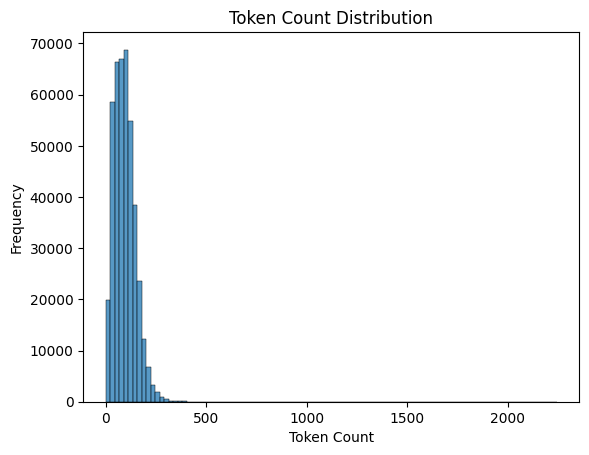

95th Percentile Cutoff: 187.0
Remaining chunks after cutoff: 402541


In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df['chunk_token_count'], bins=100)
plt.title('Token Count Distribution')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.show()

# Analyzing 95th percentile
cutoff = df['chunk_token_count'].quantile(0.95)
print(f"95th Percentile Cutoff: {cutoff}")

# Removing entries with a token count higher than the cutoff
filtered_df = df[df['chunk_token_count'] <= cutoff]
print(f"Remaining chunks after cutoff: {len(filtered_df)}")


In [17]:
# Print lower percentiles
for percentile in [5, 10, 15, 20, 25]:
    value = df['chunk_token_count'].quantile(percentile / 100.0)
    print(f"{percentile}th percentile: {value}")

5th percentile: 23.0
10th percentile: 31.0
15th percentile: 39.0
20th percentile: 47.0
25th percentile: 54.0


In [18]:
# Show random chunks with under 20 tokens in length
min_token_length = 20
for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
    print(f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')

Chunk token count: 16 | Text: Pretty sure this is a terrible explanation but feel free to fix it.
Chunk token count: 12 | Text: See my answer [here]( URL_0 ) and [here]( URL_1 )
Chunk token count: 16 | Text: The color is all wrong from the terrible, grain diet they are fed.
Chunk token count: 17 | Text: x200B; > But what if that weren’t true? \[...\] & # x200B; e: format
Chunk token count: 14 | Text: A xenophobic riot is a good way to justify theft from them.


In [19]:
chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
chunks_over_min_token_len[:2]

[{'sentence_chunk': 'the rotation of the earth is not a constant. in fact the rotation of the earth is slowing down, which means that a full day is getting slightly longer. without leap seconds our clocks would slowly drift ever so slightly out of sync with the actual day. we could deal with this by redefining how how long 1 second is, making it slightly longer so that one day is still exactly 24*60*60 seconds. but in practice that is really inconvenient for a lot of our technology which relies on very precise timing.',
  'chunk_char_count': 502,
  'chunk_word_count': 92,
  'chunk_token_count': 125},
 {'sentence_chunk': "The Earth's rotation is not regular.  It varies a bit, so sometimes we add a second.  We do this to ensure that noon is always going to be sometime around mid-day.  If we did not add leap seconds, over a very long period of time where the Earth's rotation slowly changed, noon could end up being at dusk.  We want to keep 7am in the morning, noon at mid-day, 7pm around e

### Embedding text chunks

To do so, we'll use the [`sentence-transformers`](https://www.sbert.net/docs/installation.html) library which contains many pre-trained embedding models.

Specifically, we'll get the `all-mpnet-base-v2` model.

In [20]:
# Requires !pip install sentence-transformers
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device="cpu") # choose the device to load the model to (note: GPU will often be *much* faster than CPU)

# Create a list of sentences to turn into numbers
sentences = [
    "Mommy I want to go home",
]

# Sentences are encoded/embedded by calling model.encode()
embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))

# See the embeddings
for sentence, embedding in embeddings_dict.items():
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Sentence: Mommy I want to go home
Embedding: [-2.61865277e-02  2.96979379e-02 -2.11188700e-02 -6.38349801e-02
  9.69597511e-03  1.89613085e-02  2.13039145e-02 -1.42502058e-02
 -5.08787632e-02 -2.40902174e-02 -7.45834038e-02 -4.82968539e-02
  6.40183836e-02  1.00777326e-02 -3.69258709e-02 -7.02035706e-03
 -2.82050073e-02  1.59173422e-02  7.80151866e-04  1.75831094e-02
  2.49843709e-02  1.13288956e-02 -1.39897363e-02  4.52255569e-02
  1.22692436e-03 -2.29994599e-02  4.44782972e-02  4.90870550e-02
  4.06491421e-02  1.00504877e-02 -4.89061978e-03 -1.25370743e-02
  2.03747917e-02 -4.77812588e-02  1.88157981e-06  2.84291711e-02
 -2.51195971e-02 -9.06059053e-03 -1.13941506e-02 -3.85138541e-02
 -2.87095853e-03 -1.16577655e-01  6.92831865e-03 -2.13699359e-02
  1.42580885e-02 -1.59685947e-02  4.90027443e-02  3.20232436e-02
 -5.50039625e-03  2.20027380e-02  2.59861699e-03 -2.11218260e-02
 -4.77927811e-02 -1.47669390e-02  8.21672603e-02  2.88406014e-02
  5.80045208e-03  1.12107983e-02  4.14269678e

In [21]:
single_sentence = "How cool are embeddings?"
single_embedding = embedding_model.encode(single_sentence)
print(f"Sentence: {single_sentence}")
#print(f"Embedding:\n{single_embedding}")
print(f"Embedding size: {single_embedding.shape}")

Sentence: How cool are embeddings?
Embedding size: (768,)


Our embedding has a shape of `(768,)`

> **Note:** No matter the size of the text input to our `all-mpnet-base-v2` model, it will be turned into an embedding size of `(768,)`. This value is fixed. So whether a sentence is 1 token long or 1000 tokens long, it will be truncated/padded with zeros to size 384 and then turned into an embedding vector of size `(768,)`. Of course, other embedding models may have different input/output shapes.


In [22]:
# path = '/content/drive/MyDrive/Colab Notebooks/NLP/Project'
# os.chdir(path)
# os.getcwd()

In [23]:
import os
import pickle
from tqdm.auto import tqdm

# Path to the file where the embeddings will be stored
data_filename = 'chunks_embeddings.pkl'  # Define the filename

# Function to embed and save data if not already saved
def embed_and_save_data(data, filename):
    # Load the embedding model
    # Assuming `embedding_model` is defined and loaded elsewhere in your code
    embedding_model.to("cpu")
    
    # Embed each chunk one by one
    for item in tqdm(data):
        item["embedding"] = embedding_model.encode(item["sentence_chunk"])
    
    # Save the data using pickle
    with open(filename, 'wb') as file:
        pickle.dump(data, file)
    print(f"Data embedded and saved to '{filename}'")

# Check if the data file already exists
if os.path.exists(data_filename):
    # Load the data if it already exists
    with open(data_filename, 'rb') as file:
        chunks_over_min_token_len = pickle.load(file)
    print(f"Data loaded from '{data_filename}'")
else:
    # Otherwise, process and save the data
    embed_and_save_data(chunks_over_min_token_len, data_filename)


Data loaded from 'chunks_embeddings.pkl'


In [24]:
# %%time

# # Send the model to the GPU
# embedding_model.to("cuda") # requires a GPU installed, for reference on my local machine, I'm using a NVIDIA RTX 4090

# # Create embeddings one by one on the GPU
# for item in tqdm(chunks_over_min_token_len):
#     item["embedding"] = embedding_model.encode(item["sentence_chunk"])

### Save embeddings to file

In [25]:
# Save embeddings to file
text_chunks_and_embeddings_df = pd.DataFrame(chunks_over_min_token_len)
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

In [26]:
# Import saved file and view
text_chunks_and_embedding_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embedding_df_load.head()

,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,The XBox is emulating NES hardware and running...,456,88,114,[-2.15684716e-02 -3.29913795e-02 -3.74654382e-...
1,"In that case, it's probably on purpose - they ...",539,98,134,[-5.21687604e-02 -1.29516460e-02 -5.54381870e-...
2,"Because if they were pulled taut, then a stron...",239,44,59,[-3.84662412e-02 -4.87861000e-02 3.15849460e-...
3,"There are a few reasons. First, they're metal...",310,51,77,[-2.76063364e-02 -9.72803980e-02 -2.12281290e-...
4,The lines have mass. So there is something th...,302,59,75,[ 1.75170775e-03 -6.58367351e-02 -4.83260909e-...


## 2. RAG - Search and Answer

### Similarity search

In [27]:
import random

import torch
import numpy as np
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

# Import texts and embedding df
text_chunks_and_embedding_df = pd.read_csv("text_chunks_and_embeddings_df.csv")

# Convert embedding column back to np.array (it got converted to string when it got saved to CSV)
text_chunks_and_embedding_df["embedding"] = text_chunks_and_embedding_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

# Convert texts and embedding df to list of dicts
pages_and_chunks = text_chunks_and_embedding_df.to_dict(orient="records")

# Convert embeddings to torch tensor and send to device (note: NumPy arrays are float64, torch tensors are float32 by default)
embeddings = torch.tensor(np.array(text_chunks_and_embedding_df["embedding"].tolist()), dtype=torch.float32).to(device)
embeddings.shape

torch.Size([21541, 768])

In [28]:
text_chunks_and_embedding_df.head()

,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,The XBox is emulating NES hardware and running...,456,88,114,"[-0.0215684716, -0.0329913795, -0.0374654382, ..."
1,"In that case, it's probably on purpose - they ...",539,98,134,"[-0.0521687604, -0.012951646, -0.055438187, 0...."
2,"Because if they were pulled taut, then a stron...",239,44,59,"[-0.0384662412, -0.0487861, 0.0031584946, 0.04..."
3,"There are a few reasons. First, they're metal...",310,51,77,"[-0.0276063364, -0.097280398, -0.021228129, 0...."
4,The lines have mass. So there is something th...,302,59,75,"[0.00175170775, -0.0658367351, -0.00483260909,..."


In [29]:
from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device=device) # choose the device to load the model to

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [30]:
# 1. Define the query
# Note: This could be anything.
query = "Can the president of United States fire the head of fbi?"
print(f"Query: {query}")

# 2. Embed the query to the same numerical space as the text examples
# Note: It's important to embed query with the same model you embedded your examples with.
query_embedding = embedding_model.encode(query, convert_to_tensor=True)

# 3. Get similarity scores with the dot product (we'll time this for fun)
from time import perf_counter as timer

dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]

# 4. Get the top-k results (we'll keep this to 5)
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

Query: Can the president of United States fire the head of fbi?


torch.return_types.topk(
values=tensor([0.2892, 0.2642, 0.2618, 0.2570, 0.2462]),
indices=tensor([ 2793,  2161, 16186,  1945, 12584]))

In [31]:
# Define helper function to print wrapped text
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

In [32]:
print(f"Query: '{query}'\n")
print("Results:")
# Loop through zipped together scores and indicies from torch.topk
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    # Print the page number too so we can reference the textbook further (and check the results)
    #print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    print("\n")

Query: 'Can the president of United States fire the head of fbi?'

Results:
Score: 0.2892
Text:
In Snowden's case, or anything else to do with computers, it's likley as
/u/Fishandchips321 said.  If he hasn't checked in, for whatever reason, the
automatic processes will kick in.


Score: 0.2642
Text:
Not wanting to be too glib about this but I can tell that by asking this
question that you have never worked for a government department.  The sheer
waste that goes on should be criminal.


Score: 0.2618
Text:
If this is the case, bomb disposal needs to be carefully planned and carried
out.  More likely, they will detonate it under controlled conditions.


Score: 0.2570
Text:
He will quickly be located and shut down by the FCC.  Plus, he would need some
powerful broadcasting equipment to disrupt the radio station over its whole
area.  That equipment is expensive to get and too big to hide.


Score: 0.2462
Text:
If you are a bit keen on conspiracies, you tend to ask yourself if they really
s

The workflow is:

`ingest documents -> split into chunks -> embed chunks -> make a query -> embed the query -> compare query embedding to chunk embeddings`

That's the **retrieval** part of Retrieval Augmented Generation (RAG).

### Similarity measures: dot product and cosine similarity

In our case, our embedding model `all-mpnet-base-v2` outputs normalized outputs (see the [Hugging Face model card](https://huggingface.co/sentence-transformers/all-mpnet-base-v2#usage-huggingface-transformers) for more on this) so dot product and cosine similarity return the same results. However, dot product is faster due to not need to perform a normalize step.

### Functionizing semantic search pipeline

In [33]:
import time
import textwrap
from sentence_transformers import SentenceTransformer
import torch

def retrieve_relevant_resources(query: str, embeddings: torch.tensor, model: SentenceTransformer=embedding_model, n_resources_to_return: int=5, print_time: bool=True):
    """
    Embeds a query with model and returns top k scores and indices from embeddings.
    """
    # Embed the query
    query_embedding = model.encode(query, convert_to_tensor=True)

    # Get dot product scores on embeddings
    start_time = time.time()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = time.time()

    if print_time:
        print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time - start_time:.5f} seconds.")

    scores, indices = torch.topk(input=dot_scores, k=n_resources_to_return)

    return scores, indices

def print_top_results_and_scores(query: str, embeddings: torch.tensor, chunks: list[dict] = pages_and_chunks, n_resources_to_return: int=5):
    """
    Takes a query, retrieves the most relevant resources, and prints them out in descending order.
    Assumes 'chunks' contains at least a 'sentence_chunk' key for each entry.
    """
    scores, indices = retrieve_relevant_resources(query=query, embeddings=embeddings, n_resources_to_return=n_resources_to_return)

    print(f"Query: '{query}'\nResults:")
    for score, index in zip(scores, indices):
        print(f"Score: {score.item():.4f}")  # Ensure score is printed as a float
        print("Text:")
        print(textwrap.fill(chunks[index]["sentence_chunk"], width=80))  # Wrap text for better readability
        print("\n")

In [34]:
query = "touchscreen"

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

[INFO] Time taken to get scores on 21541 embeddings: 0.00361 seconds.


(tensor([0.6369, 0.6349, 0.6149, 0.6052, 0.6017]),
 tensor([12844,  8562, 12842,  7732, 12846]))

In [35]:
# Print out the texts of the top scores
print_top_results_and_scores(query=query,
                             embeddings=embeddings)

[INFO] Time taken to get scores on 21541 embeddings: 0.00435 seconds.
Query: 'touchscreen'
Results:
Score: 0.6369
Text:
Modern touch screens are capacitive, they detect changes in an electrical field
just above the screen caused by your finger.


Score: 0.6349
Text:
There are two types of touch screens, resistive and capacitive.  Resistive works
by having multiple layers of glass and diodes, so when you push down on the
touch screen, it activates the diodes underneath transferring a message to the
CPU saying "there's a touch in X,Y".  It works via pressure on the screen.
Which is why you can use old ATMs with gloves, and could use literally anything
as a stylus for your Nintendo DS.  Capacitive touch screens are different in
that they require an electrical conduit to register input, so tapping your
finger against the screen allows the hardware to find where the current was
completed and tell the CPU where the screen was touched.


Score: 0.6149
Text:
There are two types of touch screen

In [36]:
from huggingface_hub import notebook_login

# Login to Hugging Face in the notebook to use the API token
notebook_login()

In [37]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from huggingface_hub import notebook_login


# 1. Pick a model we'd like to use
model_id = "google/gemma-7b-it"

# 2. Instantiate tokenizer (tokenizer turns text into numbers ready for the model)
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id)

# 3. Instantiate the model, specifying to use CPU-friendly settings
llm_model = AutoModelForCausalLM.from_pretrained(
    pretrained_model_name_or_path=model_id,
    torch_dtype=torch.float32,  # Use float32 for CPU to ensure compatibility
    low_cpu_mem_usage=True  # Enable this to minimize memory usage by the CPU
)

# 4. Explicitly set the model to use CPU
llm_model.to("cpu")

print("[INFO] Model and tokenizer are loaded and configured for CPU usage.")


Gemma's activation function should be approximate GeLU and not exact GeLU.
Changing the activation function to `gelu_pytorch_tanh`.if you want to use the legacy `gelu`, edit the `model.config` to set `hidden_activation=gelu`   instead of `hidden_act`. See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

[INFO] Model and tokenizer are loaded and configured for CPU usage.


In [38]:
llm_model

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 3072, padding_idx=0)
    (layers): ModuleList(
      (0-27): 28 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear(in_features=3072, out_features=4096, bias=False)
          (k_proj): Linear(in_features=3072, out_features=4096, bias=False)
          (v_proj): Linear(in_features=3072, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=3072, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=3072, out_features=24576, bias=False)
          (up_proj): Linear(in_features=3072, out_features=24576, bias=False)
          (down_proj): Linear(in_features=24576, out_features=3072, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): GemmaRMSNorm()
        (post_attention_layernorm): GemmaRMSNorm()
      )
    )
    (norm): Gemm

#### Calculate size of the model

In [39]:
def get_model_num_params(model: torch.nn.Module):
    return sum([param.numel() for param in model.parameters()])

get_model_num_params(llm_model)

8537680896

In [40]:
def get_model_mem_size(model: torch.nn.Module):
    """
    Get how much memory a PyTorch model takes up.

    See: https://discuss.pytorch.org/t/gpu-memory-that-model-uses/56822
    """
    # Get model parameters and buffer sizes
    mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
    mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])

    # Calculate various model sizes
    model_mem_bytes = mem_params + mem_buffers # in bytes
    model_mem_mb = model_mem_bytes / (1024**2) # in megabytes
    model_mem_gb = model_mem_bytes / (1024**3) # in gigabytes

    return {"model_mem_bytes": model_mem_bytes,
            "model_mem_mb": round(model_mem_mb, 2),
            "model_mem_gb": round(model_mem_gb, 2)}

get_model_mem_size(llm_model)

{'model_mem_bytes': 34150723584,
 'model_mem_mb': 32568.67,
 'model_mem_gb': 31.81}

### Generating text with our LLM

We can generate text with our LLM `model` instance by calling the [`generate()` method](https://huggingface.co/docs/transformers/v4.38.2/en/main_classes/text_generation#transformers.GenerationConfig) (this method has plenty of options to pass into it alongside the text) on it and passing it a tokenized input.

The tokenized input comes from passing a string of text to our `tokenizer`.

It's important to note that you need to use a tokenizer that has been paired with a model.

Otherwise if you try to use a different tokenizer and then pass those inputs to a model, you will likely get errors/strange results.

For some LLMs, there's a specific template you should pass to them for ideal outputs.

In this case, our `tokenizer` has a [`apply_chat_template()` method](https://huggingface.co/docs/transformers/main/en/internal/tokenization_utils#transformers.PreTrainedTokenizerBase.apply_chat_template) which can prepare our input text in the right format for the model.

In [41]:
input_text = "How does touchscreen work?"
print(f"Input text:\n{input_text}")

# Create prompt template for instruction-tuned model
dialogue_template = [
    {"role": "user",
     "content": input_text}
]

# Apply the chat template
prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                       tokenize=False, # keep as raw text (not tokenized)
                                       add_generation_prompt=True)
print(f"\nPrompt (formatted):\n{prompt}")

Input text:
How does touchscreen work?

Prompt (formatted):
<bos><start_of_turn>user
How does touchscreen work?<end_of_turn>
<start_of_turn>model



In [42]:
%%time

# Tokenize the input text (turn it into numbers) and send it to GPU
input_ids = tokenizer(prompt, return_tensors="pt").to("cpu")
print(f"Model input (tokenized):\n{input_ids}\n")

# Generate outputs passed on the tokenized input
# See generate docs: https://huggingface.co/docs/transformers/v4.38.2/en/main_classes/text_generation#transformers.GenerationConfig
outputs = llm_model.generate(**input_ids,
                             max_new_tokens=256) # define the maximum number of new tokens to create
print(f"Model output (tokens):\n{outputs[0]}\n")

Model input (tokenized):
{'input_ids': tensor([[     2,      2,    106,   1645,    108,   2299,   1721, 102692,   1160,
         235336,    107,    108,    106,   2516,    108]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

Model output (tokens):
tensor([     2,      2,    106,   1645,    108,   2299,   1721, 102692,   1160,
        235336,    107,    108,    106,   2516,    108,  21404, 235269,   1517,
        235303, 235256,    476,  25497,    576,   1368,    476, 102692,   3598,
        235292,    109,    688, 235274, 235265, 145421,  65268,  66058,    108,
        235290,  26770,  54666,   1281,  59714,  15336,    577,  21422,    573,
          8566,    576,    476,  13864,    611,    573,   4955, 235265,    108,
        235290,   3194,    692,   6437,    573,   5299, 235269,    861,  13864,
         43928,  59714,  15336, 235265,    109,    688, 235284, 235265,  69848,
         16383,  93413,  66058,    108, 235290,    714, 102692,    603,   1644,
 

In [43]:
# Decode the output tokens to text
outputs_decoded = tokenizer.decode(outputs[0])
print(f"Model output (decoded):\n{outputs_decoded}\n")

Model output (decoded):
<bos><bos><start_of_turn>user
How does touchscreen work?<end_of_turn>
<start_of_turn>model
Sure, here's a breakdown of how a touchscreen works:

**1. Electromagnetic Waves:**
- Touchscreens use electromagnetic waves to detect the presence of a finger on the surface.
- When you touch the screen, your finger generates electromagnetic waves.

**2. Capacitive Sensing:**
- The touchscreen is made up of a thin layer of conductive material, like a thin sheet of metal.
- When your finger touches the conductive layer, it alters the capacitance of the surface.

**3. Multi-Point Touch:**
- Some touchscreens can detect multiple points of contact, allowing for multi-touch gestures.
- To achieve this, the touchscreen uses specialized electrodes that can detect the unique capacitance of each point of contact.

**4. Data Conversion:**
- The changes in capacitance are converted into electrical signals.
- These signals are processed by the device's software to determine the locat

In [44]:
print(f"Input text: {input_text}\n")
print(f"Output text:\n{outputs_decoded.replace(prompt, '').replace('<bos>', '').replace('<eos>', '').replace('[INST]', '').replace('<s>', '').replace('[/INST]', '')}")

Input text: How does touchscreen work?

Output text:
Sure, here's a breakdown of how a touchscreen works:

**1. Electromagnetic Waves:**
- Touchscreens use electromagnetic waves to detect the presence of a finger on the surface.
- When you touch the screen, your finger generates electromagnetic waves.

**2. Capacitive Sensing:**
- The touchscreen is made up of a thin layer of conductive material, like a thin sheet of metal.
- When your finger touches the conductive layer, it alters the capacitance of the surface.

**3. Multi-Point Touch:**
- Some touchscreens can detect multiple points of contact, allowing for multi-touch gestures.
- To achieve this, the touchscreen uses specialized electrodes that can detect the unique capacitance of each point of contact.

**4. Data Conversion:**
- The changes in capacitance are converted into electrical signals.
- These signals are processed by the device's software to determine the location and pressure of your finger on the screen.

**5. Display R

And now let's check if our `retrieve_relevant_resources()` function works

In [45]:
import random
query = "How does touchscreen work?"

print(f"Query: {query}")

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

Query: How does touchscreen work?
[INFO] Time taken to get scores on 21541 embeddings: 0.00397 seconds.


(tensor([0.7625, 0.7511, 0.7348, 0.7097, 0.7064]),
 tensor([10888,  8562,  7732, 12846, 12842]))

### Augmenting prompt with context items

In [46]:
def prompt_formatter(query: str,
                     context_items: list[dict]) -> str:
    """
    Augments query with text-based context from context_items.
    """
    # Join context items into one dotted paragraph
    context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])

    # Create a base prompt with examples to help the model
    # Note: this is very customizable, I've chosen to use example of the answer style we'd like.
    # We could also write this in a txt file and import it in if we wanted.
    base_prompt = """Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.
\nExample 1:
Query: What are the fat-soluble vitamins?
Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitamin K is essential for blood clotting and bone metabolism.
\nNow use the following context items to answer the user query:
{context}
User query: {query}
Answer:"""

    # Update base prompt with context items and query
    base_prompt = base_prompt.format(context=context, query=query)

    # Create prompt template for instruction-tuned model
    dialogue_template = [
        {"role": "user",
        "content": base_prompt}
    ]

    # Apply the chat template
    prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                          tokenize=False,
                                          add_generation_prompt=True)
    return prompt

In [47]:
query = "How does touchscreen work?"
print(f"Query: {query}")

# Get relevant resources
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)

# Create a list of context items
context_items = [pages_and_chunks[i] for i in indices]

# Format prompt with context items
prompt = prompt_formatter(query=query,
                          context_items=context_items)
print(prompt)

Query: How does touchscreen work?
[INFO] Time taken to get scores on 21541 embeddings: 0.00448 seconds.
<bos><start_of_turn>user
Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.

Example 1:
Query: What are the fat-soluble vitamins?
Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitamin K is essential for blood clotting and bone metab

In [48]:
%%time

input_ids = tokenizer(prompt, return_tensors="pt").to("cpu")

# Generate an output of tokens
outputs = llm_model.generate(**input_ids,
                             temperature=0.7, # lower temperature = more deterministic outputs, higher temperature = more creative outputs
                             do_sample=True, # whether or not to use sampling, see https://huyenchip.com/2024/01/16/sampling.html for more
                             max_new_tokens=256) # how many new tokens to generate from prompt

# Turn the output tokens into text
output_text = tokenizer.decode(outputs[0])

print(f"Query: {query}")
print(f"RAG answer:\n{output_text.replace(prompt, '')}")

Query: How does touchscreen work?
RAG answer:
<bos>Sure, here is the answer to the user query:

Touchscreens use a capacitive touch-sensitive technology that detects changes in electrical fields caused by the presence of a human finger. This technology is commonly found in newer devices and is more precise than the resistive touchscreens that were more common in older machines like ATMs and kiosks.

When you touch a capacitive touchscreen, your finger completes a circuit that measures the exact location of your touch and sends this information to the device. The screen is coated with a thin layer of electrically charged material, and when your finger touches the screen, it disrupts the electrical field at that point. This disruption is detected by sensors in the screen, which then calculate the coordinates of your touch and translate them into a digital signal that is sent to the device.<eos>
CPU times: user 14min 37s, sys: 18.1 s, total: 14min 55s
Wall time: 4min 21s


In [49]:
import re

def clean_text(text):
    # Remove special control characters
    text = re.sub(r"<\|?bos\|?>", "", text)  # Remove any variations of beginning of string tokens
    text = re.sub(r"<\|?eos\|?>", "", text)  # Remove any variations of end of string tokens
    text = re.sub(r"</?s>", "", text)  # Remove specific separator tokens if used by your model
    text = re.sub(r"\[/?INST\]", "", text)  # Remove instruction tokens used in the output

    # Optionally, strip out additional unwanted patterns or whitespace
    text = re.sub(r"\s+", " ", text).strip()  # Collapse multiple spaces to one and trim the text
    
    return text


In [52]:
def ask(query,
        temperature=0.7,
        max_new_tokens=512,
        format_answer_text=True,
        return_answer_only=True):
    """
    Takes a query, finds relevant resources/context, and generates an answer to the query based on the relevant resources.
    """
    ### RETRIEVAL ###
    # Get just the scores and indices of top related results
    scores, indices = retrieve_relevant_resources(query=query, embeddings=embeddings)

    # Create a list of context items
    context_items = [pages_and_chunks[i] for i in indices]

    # Add score to context item
    for i, item in enumerate(context_items):
        item["score"] = scores[i].cpu() # return score back to CPU
    
    ### AUGMENTATION ###
    # Format the prompt with context items
    prompt = prompt_formatter(query=query, context_items=context_items)

    # Tokenize the prompt
    input_ids = tokenizer(prompt, return_tensors="pt").to("cpu")
    
    ### GENERATION ###
    # Generate an output of tokens
    outputs = llm_model.generate(**input_ids,
                                 temperature=temperature,
                                 do_sample=True,
                                 max_new_tokens=max_new_tokens)

    # Turn the output tokens into text
    output_text = tokenizer.decode(outputs[0])

    if format_answer_text:
        # Replace special tokens and unnecessary help message, then clean text
        output_text = output_text.replace(prompt, "")
        output_text = clean_text(output_text)  # Clean the output text using the clean_text function

    # Only return the answer without the context items
    if return_answer_only:
        return output_text

    return output_text, context_items

In [51]:
query = "How does touchscreen work?"
print(f"Query: {query}")

# Answer query with context and return context
answer, context_items = ask(query=query,
                            temperature=0.7,
                            max_new_tokens=512,
                            return_answer_only=False)

print(f"Answer:\n")
print_wrapped(answer)
#print(f"Context items:")
#context_items

Query: How does touchscreen work?
[INFO] Time taken to get scores on 21541 embeddings: 0.00390 seconds.
Answer:

Sure, here is the answer to the user query: Touchscreens use the same principle
as a fishing net with many lines running vertically and horizontally. When you
press down on the touchscreen, your fingers actually have some tiny effect on
the electric field which is measured to figure out where you tapped and how
hard. This type of touchscreen is called capacitive.


### GPT2 based RAG answear to the same question:

**Answer**: A new study from the University of North Carolina at Chapel Hill shows that women who are more likely than men to have a child with a parent who is divorced, who live with their parents in a household with at least one surviving parent, and who live with a partner who is divorced are more likely to have a partner who is divorced compared to women who live with their parents. The study found that women who had a partner who was divorced were more likely to have a child with a single parent

**Answer**: On June 30th, 2010, I was fortunate enough to attend a panel discussion
about the best ways to build a career as an entrepreneur. At the time, I had
just launched a company, and it was time to take a hard look at the new tools
and techniques that were being used to build it. I had been trying to figure out
how to build a career as an entrepreneur for a while now, so I had a few ideas
for a new way to build a career. I decided to